In [1]:
import numpy as np
import torch
import torch.nn as nn

In [2]:
# data I/O
#data = open('input.txt', 'r').read() # should be simple plain text file
data = "AB#"
chars = list(set(data))
data_size, vocab_size = len(data), 3
print('data has %d characters, %d unique.' % (data_size, vocab_size))
#char_to_ix = { ch:i for i,ch in enumerate(chars) }
#ix_to_char = { i:ch for i,ch in enumerate(chars) }
mah_char_to_ix = {'A': 0, 'B': 1, '#': 2}
mah_ix_to_char = {0: 'A', 1: 'B', 2: '#'}


data has 3 characters, 3 unique.


In [3]:
PATTERN = "ABBA"

In [4]:
def chain_exec():
  pattern = PATTERN
  ret = list(np.random.randint(2, size=len(pattern)))
  while True:
    if ''.join( mah_ix_to_char[ix] for ix in ret[-len(pattern):]) == pattern:
      return ret + [mah_char_to_ix['#']]
    else:
      ret.append(np.random.randint(2))


In [5]:
def one_hot_chain(sequence):
  xs = torch.zeros( [len(sequence), vocab_size], dtype=torch.float64)
  for t in range(len(sequence)):

    #xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
    xs[t][sequence[t]] = 1
  return torch.transpose(torch.tensor(xs), 1,0)


In [6]:
''.join([ mah_ix_to_char[x] for x in chain_exec()])

'ABBBBBBBBABABBBBABABBBBBAABBA#'

In [7]:
from sklearn.manifold import TSNE

In [8]:
hidden_states = list()
states = list()

In [9]:
# STATE_NOTHING = 0
# STATE_A = 1
# STATE_AA = 2
# STATE_AAB = 3
# STATE_AABB = 4
# STATE_FINITO = 5


In [10]:
class Automata:
  def __init__(self, pattern):
    self.pattern = pattern + "#"
    self.state = ""

    # self.state = dict()
    # for i in range(len(pattern)+1):
    #   self.state[pattern[:i]] = dict()

    # print(self.state)
    # pass

  def transition(self, char):
    tentative_state = self.state + char
    #print(tentative_state)
    if tentative_state == self.pattern[:len(tentative_state)]:
      self.state = tentative_state
      #print("idziemy dalej", self.state)
    else:
      #print("kasza")
      for i in range(len(tentative_state)+1):
        #print(tentative_state[i:], "vs", self.pattern[:len(tentative_state)-i])
        if tentative_state[i:] == self.pattern[:len(tentative_state)-i]:
          self.state = tentative_state[i:]
          #print("najlepszy match to |", tentative_state[i:],"|")
          break
    return self.state

  def hsh(self):
    return len(self.state)

In [11]:
automat = Automata(PATTERN)
cur_state = automat.state

In [12]:
''.join([ mah_ix_to_char[x] for x in chain_exec()])

'BAAABBA#'

In [13]:
for char in ''.join([ mah_ix_to_char[x] for x in chain_exec()]):
  print("pushing char", char, "current state is [",automat.state,"]",  "new state is", automat.transition(char))


pushing char A current state is [  ] new state is A
pushing char A current state is [ A ] new state is A
pushing char A current state is [ A ] new state is A
pushing char B current state is [ A ] new state is AB
pushing char B current state is [ AB ] new state is ABB
pushing char A current state is [ ABB ] new state is ABBA
pushing char # current state is [ ABBA ] new state is ABBA#


In [14]:
def sample(seed_ix):
  """
  sample a sequence of integers from the model
  seed_ix is seed letter for first time step
  """
  # x = np.zeros((vocab_size, 1))
  # x[seed_ix] = 1
  x = seed_ix
  ixes = []

  h = torch.zeros([hidden_size, 1], dtype=torch.float64)


  #for t in range(n):
  t = 0
  while True:
    h = torch.tanh( torch.matmul(Wxh, x).add( torch.matmul( Whh, h).add(bh)))
    y = torch.matmul(Why, h).add(by)
    ps = torch.nn.functional.softmax(y, dim=0)
    ix = np.random.choice(range(vocab_size), p=ps.detach().numpy().ravel())
    x = torch.zeros((vocab_size, 1), dtype=torch.float64)
    x[ix] = 1
    ixes.append(ix)
    if mah_ix_to_char[ix] == '#':
      break
  if len(ixes) <= 4:
    return sample(seed_ix)
  return ixes

In [15]:
def lossFunNasze(inputs, targets):

  n = inputs.size()[1]

  h = torch.zeros([hidden_size, 1], dtype=torch.float64, requires_grad=True)
  h_prev = torch.zeros([hidden_size, 1], dtype=torch.float64, requires_grad=True)
  loss = torch.zeros( [1], dtype=torch.float64, requires_grad=True)

  automat = Automata(PATTERN)
  state = automat.state

  weights = torch.tensor( [1., 1., 1.], dtype=torch.float64)

  for t in range(n):
    #h = torch.tanh( torch.matmul(Wxh, inputs[:,[t]]).add( torch.matmul( Whh, h_prev).add(bh)))
    h = torch.tanh( Wxh @ inputs[:,[t]] +  Whh @ h_prev + bh)

    hidden_states.append(h.detach().clone())
    state = automat.transition(token2char(inputs[:,[t]]))
    states.append( automat.hsh())
    
    y = torch.matmul(Why, h).add(by)
    ps = torch.nn.functional.softmax(y, dim=0)

    loss = loss - (torch.matmul(weights, ps)).mul(torch.log( torch.matmul(torch.transpose(ps, 1, 0), targets[:, [t]])))

    h_prev = h
  #print(2137, loss/n)
  return loss/n

In [16]:
import math

# hyperparameters
hidden_size = 3 # size of hidden layer of neurons
#seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

# model parameters
Wxh = torch.tensor(np.random.randn(hidden_size, vocab_size)*0.1, requires_grad=True) # input to hidden
Whh = torch.tensor(np.random.randn(hidden_size, hidden_size)*0.1, requires_grad=True) # hidden to hidden
Why = torch.tensor(np.random.randn(vocab_size, hidden_size)*0.0, requires_grad=True) # hidden to output
bh = torch.tensor(np.random.randn(hidden_size, 1)*0.1, requires_grad=True) # hidden bias
by = torch.tensor(np.random.randn(vocab_size, 1)*0.1, requires_grad=True) # output bias

learning_rate = 1e-1
mWxh = torch.zeros_like(Wxh)
mWhh = torch.zeros_like(Whh)
mWhy = torch.zeros_like(Why)
mbh = torch.zeros_like(bh)
mby = torch.zeros_like(by)


In [17]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def token2char(token):
    if token.numpy().item(0) == 1.:
        char = 'A'
    elif token.numpy().item(1) == 1.:
        char = 'B'
    elif token.numpy().item(2) == 1.:
        char = '#'
    return char

def viz(hidden_states, states, ax=None, opacity=0.5):
    clear_output(wait=True)
    last_hidden_states = hidden_states[-1000:]
    last_states = states[-1000:]
    states_np = [h_tensor.numpy() for h_tensor in last_hidden_states]
    states_np = np.asarray(states_np).reshape(-1, hidden_size)

    # Dimensionality reduction using PCA
    pca = PCA(n_components=2)
    X_embedded = pca.fit_transform(states_np)

    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 9))

    # Clear the axis for fresh plotting
    ax.clear()

    # Normalize colors based on states
    normalized_states = (np.array(last_states) - min(last_states)) / (max(last_states) - min(last_states))
    colors = plt.cm.viridis(normalized_states)

    # Plot lines connecting consecutive points with colors matching the originating state
    for i in range(len(X_embedded) - 1):
        ax.plot(
            [X_embedded[i, 0], X_embedded[i + 1, 0]],
            [X_embedded[i, 1], X_embedded[i + 1, 1]],
            color=colors[i],
            linewidth=0.5,
            alpha=opacity,  # Set transparency
            zorder=1  # Lower priority for the lines
        )

    # Scatter plot with the reduced dimensions
    scatter = ax.scatter(
        X_embedded[:, 0], X_embedded[:, 1], c=last_states, cmap='viridis', zorder=2
    )

    # Add legend
    legend1 = ax.legend(
        handles=scatter.legend_elements()[0],
        labels=[PATTERN[:i] for i in range(len(PATTERN + "#"))],
        title="STATES"
    )
    ax.add_artist(legend1)

    # Set titles and labels
    ax.set_title("Hidden States Visualization")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")

    # Display and refresh the plot
    display(ax.figure)
    plt.pause(0.1)


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by PCA.

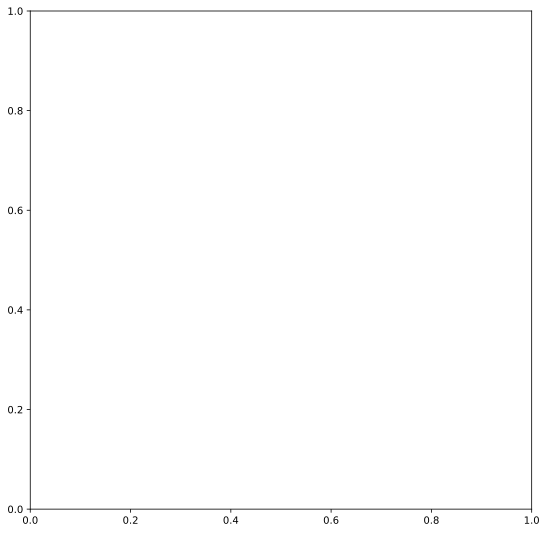

In [18]:
# Initialize the figure and axis for persistent plotting
fig, ax = plt.subplots(figsize=(9, 9))

i = 0
while True:
    i += 1
    if i % 100 == 0:
        ixes = sample(one_hot_chain(chain_exec())[:, [0]])
        ixes_AB = ''.join([mah_ix_to_char[x] for x in ixes])
#        print(i, "\t", len(ixes_AB) - ixes_AB.find(PATTERN), ixes_AB[-len(PATTERN) - 1:], ixes_AB)

    if i % (1000 if i < 100 else 1000) == 1:
        viz(hidden_states, states, ax=ax)


    inputs = one_hot_chain(chain_exec())
    targets = inputs[:, 1:]
    inputs = inputs[:, :-1]

    loss = lossFunNasze(inputs, targets)
    loss.backward()

    with torch.no_grad():
        for param, mem in zip([Wxh, Whh, Why, bh, by], [mWxh, mWhh, mWhy, mbh, mby]):
            mem += param.grad.mul(param.grad)
            param += -learning_rate * param.grad / torch.sqrt(mem + 1e-8)
            param.grad.zero_()


/tmp/ipykernel_17929/366542704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.transpose(torch.tensor(xs), 1,0)


100 	 0.7434830383913793 	 5 ABBA# AAAABBA#
200 	 0.7068870521251388 	 5 ABBA# ABBBBBBBAAAABAABABBA#
300 	 0.6641278386491312 	 5 ABBA# BBAABBBAABBBBBAABBA#
400 	 0.67528915776463 	 12 BBBA# ABAABABBBA#
500 	 0.7339868903630926 	 5 ABBA# AAABAABBA#
600 	 0.5822567958813708 	 5 ABBA# ABBA#
700 	 0.627580345099515 	 5 ABBA# ABABAABBBABAAAABAAAABBA#
800 	 0.7622552987345032 	 5 ABBA# BBBBBABAABBBBBBBAABBA#
900 	 0.5893788932196249 	 5 ABBA# ABAABBA#
1100 	 0.6476666385246548 	 5 ABBA# BABBA#
1200 	 0.6013945601871986 	 5 ABBA# ABBA#
1300 	 0.6737457467979336 	 5 ABBA# AABAAABBA#
1400 	 0.5998992121467026 	 5 ABBA# BAABBBBBBABAAAAAABBA#
1500 	 0.5975455527733244 	 5 ABBA# AABBA#
1600 	 0.6326717216174166 	 5 ABBA# BAABAAAAABBA#
1700 	 0.6180294413734668 	 5 ABBA# ABABBBAABAAABBBAABAABBA#
1800 	 0.6966772844413343 	 23 ABBA# BABAABABABBABBBBABBBAAABABABBA#
1900 	 0.40005114311767964 	 5 ABBA# BAABABBA#
2100 	 0.7109780527248242 	 5 ABBA# ABABBBBBAABABBA#
2200 	 0.6877926611450985 	 5 ABBA# 

KeyboardInterrupt: 

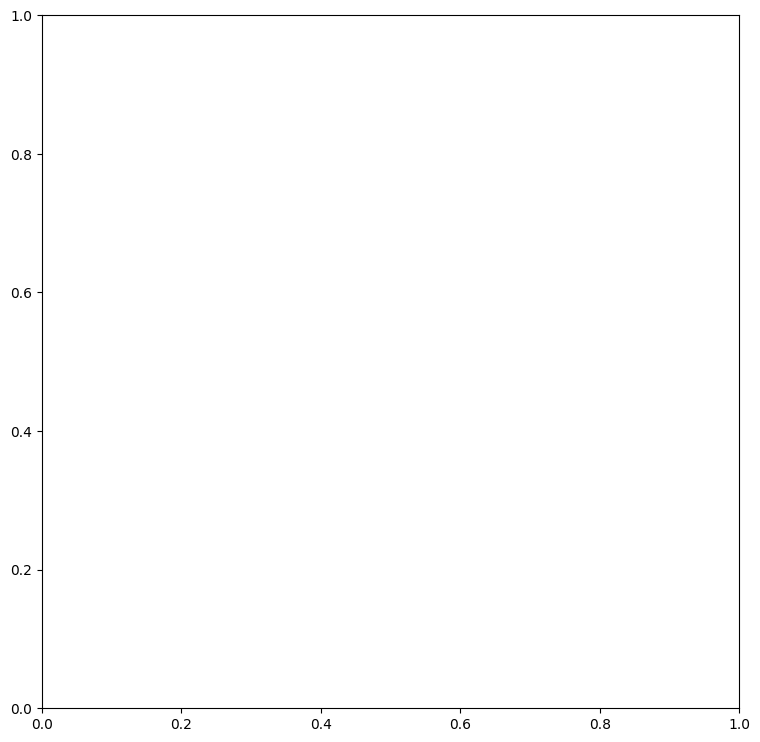

In [ ]:
# Initialize the figure and axis for persistent plotting
fig, ax = plt.subplots(figsize=(9, 9))

i = 0
while True:
    i += 1

    if i % 1000 == 0:
        continue
#        viz(hidden_states, states, ax=ax)


    inputs = one_hot_chain(chain_exec())
    targets = inputs[:, 1:]
    inputs = inputs[:, :-1]

    loss = lossFunNasze(inputs, targets)
    loss.backward()
    if i % 100 == 0:
        ixes = sample(one_hot_chain(chain_exec())[:, [0]])
        ixes_AB = ''.join([mah_ix_to_char[x] for x in ixes])
        print(i, "\t", loss.item(), "\t", len(ixes_AB) - ixes_AB.find(PATTERN), ixes_AB[-len(PATTERN) - 1:], ixes_AB)

    with torch.no_grad():
        for param, mem in zip([Wxh, Whh, Why, bh, by], [mWxh, mWhh, mWhy, mbh, mby]):
            mem += param.grad.mul(param.grad)
            param += -learning_rate * param.grad / torch.sqrt(mem + 1e-8)
            param.grad.zero_()



stringi mają postać $x_1x_2\ldots x_l\text{'='}y$ gdzie $x_1,...,x_l \in {'A','B'}$, a $y \in \{'0','1'\}$


$y = f(\text{pattern of A and B})$

where 
$f(\text{pattern of A and B}) = [\text{AABBAA exists}]$

$f(\text{pattern of A and B}) = \max([\text{AABBAA exists}], [\text{BABABA exists}])$

$f(\text{pattern of A and B}) = 3*[\text{AABBAA exists}] + 4 * [\text{BABABA exists}]$

and

$[bool] = \begin{cases} 
0 & \text{if } False \\
1 & \text{if } True 
\end{cases}$

In [ ]:
import numpy as np


PATTERN1 = "AABBAA"
PATTERN2 = "AABBAA"

# Updated dictionaries
mah_char_to_ix = {'A': 0, 'B': 1, '#': 2, '?': 3, '=': 4, '0': 5, '1': 6}
mah_ix_to_char = {0: 'A', 1: 'B', 2: '#', 3: '?', 4: '=', 5: '0', 6: '1'}


def chain_exec_modified():
    l = np.random.randint(11, 89)  # Generate random l between 11 and 88
    sequence = [np.random.randint(2) for _ in range(l)]  # Generate l random A or B

    # Convert to string before noise for pattern check
    sequence_str_original = ''.join(mah_ix_to_char[ix] for ix in sequence)

    # Check for patterns in original string
    if PATTERN1 in sequence_str_original or PATTERN2 in sequence_str_original:
        label = mah_char_to_ix['1']  # 1 if pattern found
    else:
        label = mah_char_to_ix['0']  # 0 otherwise
    
    # Add noise to the sequence
    for i in range(len(sequence)):
        if np.random.rand() < 0.1:  # With probability 0.1
            sequence[i] = mah_char_to_ix['?']  # Replace with '?'

    result = sequence + [mah_char_to_ix['=']] + [label] 
    return result

In [ ]:
for _ in range(100):
    print(''.join([mah_ix_to_char[x] for x in chain_exec_modified()]))

BAABBBA?ABBBB?BABAAABABBAABBBABBBAB?A?AAAA?AAAABBABB?AB?ABBAABA=0
BBBBAAABB?AA?BBBAB?AABB?A?BABAB?BBBB=1
ABBBBBBAAABBB??BBBBAA?AB=0
AAABAABB?A?AAAAABAB?BABBAABBAABBABAABABBABAABABAAAAAAAA=1
BBBBB?AAA?ABAABBAB?B?=0
ABBABBBBBABAAAABBAAAAABBBAAA?ABBAA?BBBBBBABBBABBABA?BABAA?BBABBAABABBBABBABABAAAABBABBBA=1
BABB??ABBAABAABBB?BABAABBABAAABBBAABBB?BBBBBABABBA=1
BABAABBAAAABAAA?ABAA?ABB=1
BBBAB?ABABBABAA?BA?A?ABBB?AB?BBBABB?BA?ABABABBAAAAA=0
ABBAAB?AAABABB?ABBABBB?BA=0
?AAABABAABABBABBBBBB?BBBBBABABAABBBAABBBAAAABAAABBA?BABAAAAABABBABBAAABABA=1
AAAB?ABBBBBBAAABABBBABAB=0
?ABAAAAAABAABABBBBAA??=0
?ABBBAA?ABAAAA?B?BAABAABA?AAB=0
BAAABABBAAAABBBABBAA?ABBBBABBAABABAAABAABBAABB?BABABBAABAAABABBB?ABA=1
BBBAAABB?BAABAAAABAB?BAABABBABAAB?=0
ABAABBABBBA?BA?BABBBAABAAAABABBABAAABABAB?AABBA?A?BBAAABBAABB?BABABBBAAABBBBBBAAAAB?=1
BBBABBBBABBABA?BBBBBB?BBAABBAAABBBBBAAAAABA=1
?BBAAAAABBABABAAAB?ABBBAABBBB?B?BBABAAAABBB?BBBABBAABAABAABAAA?AB?BAB?AABB=1
BBABABABBBAABBBABABAAABB?A??BBAAAABA?AAAA???BAABBABAAB